In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# In the data directory look for data bundles (directories with 2 csv files key_events.csv and landmarks.csv)
import os
data_dir = 'data'
data_bundles = [os.path.join(data_dir, d) for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

In [3]:
def load_data(bundle_path):
    key_events_path = os.path.join(bundle_path, 'key_events.csv')
    landmarks_path = os.path.join(bundle_path, 'landmarks.csv')
    
    key_events = pd.read_csv(key_events_path)
    landmarks = pd.read_csv(landmarks_path)
    
    return key_events, landmarks

key_events, landmarks = load_data(data_bundles[0])

landmarks.drop(columns=['hand_label', 'world_x', 'world_y', 'world_z'], inplace=True)

landmarks.dtypes

# landmark_index column
# 0. WRIST
# 1. THUMB_CMC
# 2. THUMB_MCP
# 3. THUMB_IP
# 4. THUMB_TIP
# 5. INDEX_FINGER_MCP
# 6. INDEX_FINGER_PIP
# 7. INDEX_FINGER_DIP
# 8. INDEX_FINGER_TIP
# 9. MIDDLE_FINGER_MCP
# 10. MIDDLE_FINGER_PIP
# 11. MIDDLE_FINGER_DIP
# 12. MIDDLE_FINGER_TIP
# 13. RING_FINGER_MCP
# 14. RING_FINGER_PIP
# 15. RING_FINGER_DIP
# 16. RING_FINGER_TIP
# 17. PINKY_MCP
# 18. PINKY_PIP
# 19. PINKY_DIP
# 20. PINKY_TIP


session_frame       int64
timestamp           int64
hand_index          int64
hand_score        float64
landmark_index      int64
x                 float64
y                 float64
z                 float64
dtype: object

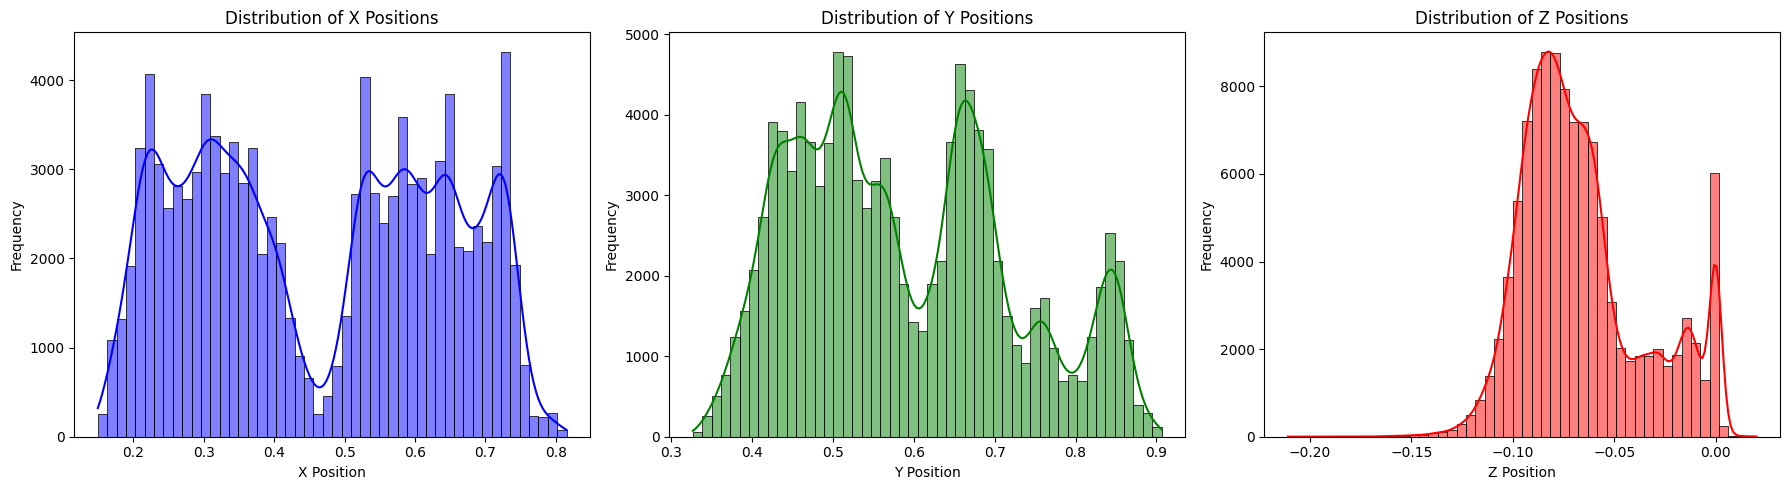

In [4]:
# Plot the distributions of x,y,z positions of all landmarks
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(landmarks['x'], bins=50, kde=True, color='blue')
plt.title('Distribution of X Positions')
plt.xlabel('X Position')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
sns.histplot(landmarks['y'], bins=50, kde=True, color='green')
plt.title('Distribution of Y Positions')
plt.xlabel('Y Position')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
sns.histplot(landmarks['z'], bins=50, kde=True, color='red')
plt.title('Distribution of Z Positions')
plt.xlabel('Z Position')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



In [5]:
# Get the diffs of each joint between frames
landmarks.sort_values(by=['session_frame', 'landmark_index'], inplace=True)
landmarks[['x_diff', 'y_diff', 'z_diff']] = landmarks.groupby(['landmark_index', 'hand_index'])[['x', 'y', 'z']].diff().fillna(0)
landmarks.sort_values(by=['session_frame', 'hand_index'], inplace=True)
landmarks

,session_frame,timestamp,hand_index,hand_score,landmark_index,x,y,z,x_diff,y_diff,z_diff
0,0,5472461,0,0.997706,0,0.217616,0.872263,1.548826e-07,0.000000,0.000000,0.000000
1,0,5472461,0,0.997706,1,0.301861,0.843252,-1.344533e-03,0.000000,0.000000,0.000000
2,0,5472461,0,0.997706,2,0.359311,0.772887,-1.142256e-02,0.000000,0.000000,0.000000
3,0,5472461,0,0.997706,3,0.373090,0.668426,-1.742231e-02,0.000000,0.000000,0.000000
4,0,5472461,0,0.997706,4,0.371063,0.593872,-2.501471e-02,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
110455,2629,5561561,1,0.984848,16,0.597938,0.472456,-1.198372e-01,0.004051,-0.001823,-0.007223
110456,2629,5561561,1,0.984848,17,0.733062,0.671988,-7.379452e-02,0.003093,-0.000399,-0.006082
110457,2629,5561561,1,0.984848,18,0.728253,0.579384,-9.665759e-02,0.002092,-0.001340,-0.006409
110458,2629,5561561,1,0.984848,19,0.708222,0.525204,-1.103482e-01,0.001089,-0.003199,-0.007147


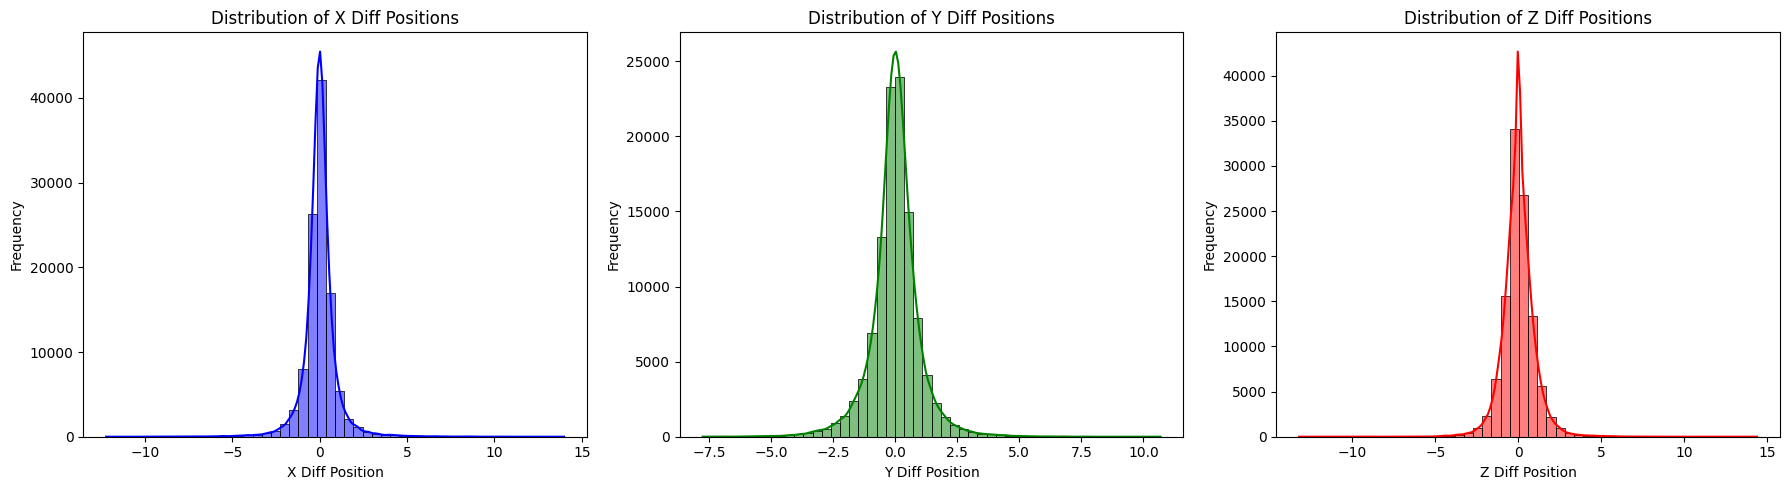

In [6]:
# Standardize the diff columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
landmarks[['x_diff', 'y_diff', 'z_diff']] = scaler.fit_transform(landmarks[['x_diff', 'y_diff', 'z_diff']])

# Plot the distributions of x_diff,y_diff,z_diff positions of all landmarks
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(landmarks['x_diff'], bins=50, kde=True, color='blue')
plt.title('Distribution of X Diff Positions')
plt.xlabel('X Diff Position')
plt.ylabel('Frequency')
plt.subplot(1, 3, 2)
sns.histplot(landmarks['y_diff'], bins=50, kde=True, color='green')
plt.title('Distribution of Y Diff Positions')
plt.xlabel('Y Diff Position')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
sns.histplot(landmarks['z_diff'], bins=50, kde=True, color='red')
plt.title('Distribution of Z Diff Positions')
plt.xlabel('Z Diff Position')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [7]:
# Pivot the landmarks dataframe to have one row per session_frame and hand_index, and columns for each landmark's x_diff, y_diff, z_diff
landmarks_pivot = landmarks.pivot_table(index=['timestamp', 'session_frame', 'hand_index'], columns='landmark_index', values=['x', 'y','z','x_diff', 'y_diff', 'z_diff'])
landmarks_pivot.columns = [f'{axis}_{idx}' for axis, idx in landmarks_pivot.columns]
landmarks_pivot.reset_index(inplace=True)
landmarks_pivot

,timestamp,session_frame,hand_index,x_0,x_1,x_2,x_3,x_4,x_5,x_6,...,z_diff_11,z_diff_12,z_diff_13,z_diff_14,z_diff_15,z_diff_16,z_diff_17,z_diff_18,z_diff_19,z_diff_20
0,5472461,0,0,0.217616,0.301861,0.359311,0.373090,0.371063,0.325247,0.362718,...,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947
1,5472461,0,1,0.737426,0.653085,0.592999,0.561206,0.551169,0.598732,0.528647,...,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947,0.000947
2,5472492,1,0,0.224474,0.304552,0.358343,0.377889,0.379143,0.323622,0.360919,...,-0.924327,-0.947660,0.172192,-0.352257,-1.061994,-1.491598,0.068418,-0.700706,-1.547762,-2.060254
3,5472492,1,1,0.738157,0.658322,0.597245,0.562155,0.547155,0.600236,0.527173,...,-0.383885,-0.922256,-0.070521,0.390405,0.229454,-0.131698,-0.133662,0.151105,0.269809,0.274863
4,5472525,2,0,0.220939,0.302623,0.355997,0.374756,0.377166,0.319988,0.357752,...,0.157747,0.199448,0.398255,0.305324,0.209413,0.226241,0.532434,0.360167,0.208973,0.172344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,5561497,2627,1,0.732613,0.652153,0.591608,0.554707,0.537500,0.599658,0.537225,...,-1.920392,-2.310892,-1.200462,-1.437277,-1.743360,-2.067888,-1.206627,-1.440573,-1.674354,-1.946411
5256,5561529,2628,0,0.209667,0.293421,0.349301,0.370871,0.382310,0.301871,0.325283,...,1.062213,1.362576,0.492887,0.863647,1.141245,1.343269,0.558917,1.128044,1.532862,1.788373
5257,5561529,2628,1,0.732783,0.653188,0.595161,0.563297,0.551878,0.603000,0.541807,...,0.575786,0.714299,0.162490,0.412325,0.521686,0.542134,0.288271,0.408473,0.483289,0.521992
5258,5561561,2629,0,0.208258,0.291608,0.346773,0.369192,0.374130,0.301101,0.326104,...,0.357315,0.397917,0.199352,0.204026,0.259463,0.304900,0.144261,0.114773,0.110279,0.111431


In [8]:
delay_ms = 37

# load the key events dataset (if not already loaded)
key_events = pd.read_csv(os.path.join(data_bundles[0], 'key_events.csv'))

# Create a copy of the landmarks timestamp with the delay removed.
landmarks_pivot['adjusted_timestamp'] = landmarks_pivot['timestamp'] - delay_ms

# Merge landmarks with key_events using merge_asof.
matched_frames = pd.merge_asof(
    landmarks_pivot.sort_values('adjusted_timestamp'),
    key_events.sort_values('timestamp'),
    left_on='adjusted_timestamp',
    right_on='timestamp',
    direction='nearest',
    suffixes=('', '_key'),
    tolerance=50  # Only merge if within 50ms
)

matched_frames.sort_values(by=['timestamp', 'session_frame', 'hand_index'], inplace=True)
# Create an uppercase label consisting of the key and whether it was DOWN (pressed=1) or UP (pressed=0)
matched_frames['label'] = matched_frames.apply(lambda row: f"{str(int(row['key_code'])).upper()}_{'DOWN' if row['pressed'] == 1 else 'UP'}" if pd.notnull(row['key_code']) else 'NO_KEY', axis=1)
matched_frames


,timestamp,session_frame,hand_index,x_0,x_1,x_2,x_3,x_4,x_5,x_6,...,z_diff_17,z_diff_18,z_diff_19,z_diff_20,adjusted_timestamp,timestamp_key,key_code,scan_code,pressed,label
0,5472461,0,0,0.217616,0.301861,0.359311,0.373090,0.371063,0.325247,0.362718,...,0.000947,0.000947,0.000947,0.000947,5472424,NaN,NaN,NaN,NaN,NO_KEY
1,5472461,0,1,0.737426,0.653085,0.592999,0.561206,0.551169,0.598732,0.528647,...,0.000947,0.000947,0.000947,0.000947,5472424,NaN,NaN,NaN,NaN,NO_KEY
2,5472492,1,0,0.224474,0.304552,0.358343,0.377889,0.379143,0.323622,0.360919,...,0.068418,-0.700706,-1.547762,-2.060254,5472455,5472500.0,32.0,57.0,0.0,32_UP
3,5472492,1,1,0.738157,0.658322,0.597245,0.562155,0.547155,0.600236,0.527173,...,-0.133662,0.151105,0.269809,0.274863,5472455,5472500.0,32.0,57.0,0.0,32_UP
4,5472525,2,0,0.220939,0.302623,0.355997,0.374756,0.377166,0.319988,0.357752,...,0.532434,0.360167,0.208973,0.172344,5472488,5472500.0,32.0,57.0,0.0,32_UP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,5561497,2627,1,0.732613,0.652153,0.591608,0.554707,0.537500,0.599658,0.537225,...,-1.206627,-1.440573,-1.674354,-1.946411,5561460,NaN,NaN,NaN,NaN,NO_KEY
5256,5561529,2628,0,0.209667,0.293421,0.349301,0.370871,0.382310,0.301871,0.325283,...,0.558917,1.128044,1.532862,1.788373,5561492,NaN,NaN,NaN,NaN,NO_KEY
5257,5561529,2628,1,0.732783,0.653188,0.595161,0.563297,0.551878,0.603000,0.541807,...,0.288271,0.408473,0.483289,0.521992,5561492,NaN,NaN,NaN,NaN,NO_KEY
5258,5561561,2629,0,0.208258,0.291608,0.346773,0.369192,0.374130,0.301101,0.326104,...,0.144261,0.114773,0.110279,0.111431,5561524,NaN,NaN,NaN,NaN,NO_KEY
